In [7]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# 1 Creation de la base de donné et importation des données du fichier csv

    # 1.1 Creation de la base de donné et de la table Questions

In [2]:
if not os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db')  # Creation de la base de données
    c = conn.cursor() # La base de données sera enregistré dans le dossier courant
    # Creation de la table Questions
    c.execute('''CREATE TABLE Questions
                 ([Id] INTEGER PRIMARY KEY,[Title] text, [Body] text, [Tags] text)''')
    conn.commit()
    conn.close()
    print("Base donnée crée")
else:
    print("Base donnée existe déja")

Base donnée existe déja


    # 1.2 Importation des données du fichier Train.csv

In [6]:
if os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db')  
    start = datetime.now()
    read_data = pd.read_csv (r'/Users/chems/Desktop/facebook-recruiting-iii-keyword-extraction/Train.csv')
    read_data.to_sql('Questions', conn, if_exists='append', index = False)
    print("Données chargées avec succes en :",datetime.now()-start)
    conn.close()
else:
    print('Base de données absente')

Données chargées avec succes en : 0:14:49.563977


In [33]:
#Calcul de nombre de lignes 
if os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db')
    c = conn.cursor()
    start = datetime.now()
    num_rows = pd.read_sql_query("""SELECT count(*) FROM Questions""", conn)
    conn.close()
    print("nombre de lignes est : ",num_rows['count(*)'].values[0])
    print("temps de calcul des lignes est :",datetime.now()-start)
else:
    print('Base de données absente')

nombre de lignes est :  4206314
temps de calcul des lignes est : 0:00:46.491080


    # 1.3 Suppression de données dupliquées

In [4]:
if os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db')
    start = datetime.now()
    
    #selection de lignes dupliquées
    selectQuery =  "SELECT Id, Title, Body, Tags FROM Questions WHERE Id not in (SELECT MAX(Id) FROM Questions GROUP BY Title, Body, Tags)"
    data = pd.read_sql_query(selectQuery,conn)
    conn.close()
    data.head();
    #print("nombre de lignes dupliquées est",data.shape[0],"ce qui fait",(data.shape[0]/num_rows['count(*)'].values[0])*100,"% de données")
    print("nombre de lignes dupliquées est",data.shape[0])

    print("temps de l'opération est :",datetime.now()-start)
else:
    print('Base de données absente')



nombre de lignes dupliquées est 0
temps de l'opération est : 0:05:13.238655


In [2]:
#suppression de lignes dupliqées
if os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db')
    c = conn.cursor()
    deleteQuery =  """DELETE FROM Questions WHERE Id not in (SELECT MAX(Id) FROM Questions GROUP BY Title, Body, Tags)"""
    start = datetime.now()
    c.execute(deleteQuery)
    conn.commit()
    conn.close()
    print("temps de l'operation",datetime.now()-start)
else:
    print('Base de données absente')

temps de l'operation 0:08:27.313598


# 2 Analyse des tags
    # 2.1 Chargement de tags

In [7]:
if os.path.isfile('train.db'):
    start = datetime.now()
    conn = sqlite3.connect('train.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM Questions""", conn)
    conn.close()
    tag_data.head()
    print("temps de calcul de lignes :", datetime.now() - start)
else:
    print('Base de données absente')


temps de calcul de lignes : 0:00:52.906567


    # 2.2 Calcul du nombre de tags unique

In [4]:
print(len(tag_data))
vectorizer = CountVectorizer(tokenizer= lambda x:x.split())
start = datetime.now()
tag_dtm = vectorizer.fit_transform(tag_data['Tags'].values.astype(str))

print("Nombre de points :", tag_dtm.shape[0])
print("Nombre de tags :", tag_dtm.shape[1])
print("temps de l'operation est :", datetime.now() - start)


4206314
Nombre de points : 4206314
Nombre de tags : 42049
temps de l'operation est : 0:00:21.586787


    #2.3 Frequences des tags

In [4]:
tags = vectorizer.get_feature_names()
print("Selection de 10 tags :", tags[:10])
freqs = tag_dtm.sum(axis=0).A1 #calculer la fréquence de chaque tag
result = dict(zip(tags, freqs))
print(result)

Selection de 10 tags : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']
{'.a': 18, '.app': 37, '.asp.net-mvc': 1, '.aspxauth': 21, '.bash-profile': 138, '.class-file': 53, '.cs-file': 14, '.doc': 47, '.drv': 1, '.ds-store': 8, '.each': 184, '.emf': 33, '.exe': 27, '.exe.config': 1, '.hgtags': 6, '.htaccess': 14884, '.htpasswd': 61, '.ico': 10, '.lib': 20, '.lrc': 4, '.mobi': 2, '.mov': 16, '.net': 114087, '.net-1.0': 19, '.net-1.1': 218, '.net-2.0': 1661, '.net-3.0': 55, '.net-3.5': 3693, '.net-4.0': 5020, '.net-4.0-beta-2': 16, '.net-4.0-rc1': 6, '.net-4.5': 695, '.net-assembly': 516, '.net-authorization': 2, '.net-bcl': 2, '.net-bugs': 1, '.net-cf-3.5': 61, '.net-client-profile': 53, '.net-compact': 1, '.net-framework': 235, '.net-framework-source': 15, '.net-framework-version': 73, '.net-gadgeteer': 12, '.net-install': 7, '.net-internals': 4, '.net-interview': 3, '.net-micro-framework': 103, '.net-reflector': 24, '.

In [12]:
if os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db') 
    c = conn.cursor()
    start = datetime.now()
    #c.execute('''CREATE TABLE IF NOT EXISTS Tags
                 #([Tags] text, [Count] number)''')
    for key,value in result.items():
        InsertRow = """INSERT INTO Tags VALUES ('{}',{})""".format(key,value)
        c.execute(InsertRow)
        conn.commit()

    print("Données insérées avec succes en :",datetime.now()-start)
    conn.close()
else:
    print('Base de données absente')
    
    

Données insérées avec succes en : 0:00:49.762273


    #2.4 Représentation graphique de la distrubtion  des tags

In [7]:
if os.path.isfile('train.db'):
    start = datetime.now()
    conn = sqlite3.connect('train.db')
    tag_counts = pd.read_sql_query("""SELECT Tags, Count FROM Tags ORDER BY Count DESC""", conn)
    conn.close()
    tag_counts.head()
    print("temps de calcul de lignes :", datetime.now() - start)
else:
    print('Base de données absente')
    
    

temps de calcul de lignes : 0:00:00.121658


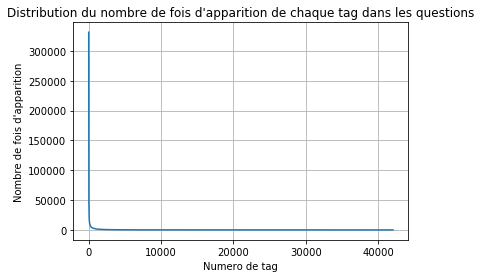

In [8]:
plt.plot(tag_counts['Count'].values)
plt.title("Distribution du nombre de fois d'apparition de chaque tag dans les questions")
plt.grid()
plt.xlabel("Numero de tag")
plt.ylabel("Nombre de fois d'apparition")
plt.show()

On remarque que le premier tag apparait plus de 300000 fois et le dernier tag apparait seulement une fois. On peut dire alors que c'est une distribution asymétrique.


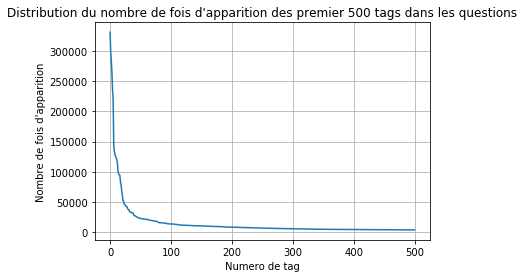

In [4]:
plt.plot(tag_counts['Count'].values[:500])
plt.title("Distribution du nombre de fois d'apparition des premiers 500 tags dans les questions")
plt.grid()
plt.xlabel("Numero de tag")
plt.ylabel("Nombre de fois d'apparition")
plt.show()

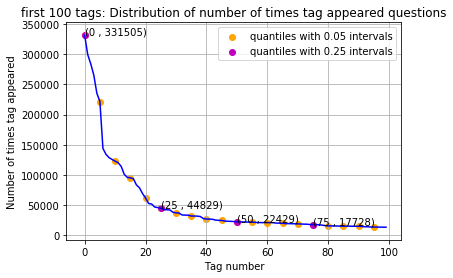

In [7]:
plt.plot(tag_counts['Count'].values[:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts['Count'].values[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts['Count'].values[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts['Count'].values[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [17]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_counts[tag_counts['Count']>10000].Tags
#Print the length of the list
print ('{} Tags sont utilisés 10000 fois'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_counts[tag_counts['Count']>100000].Tags
#Print the length of the list.
print ('{} Tags sont utilisés plus de 100000 fois'.format(len(lst_tags_gt_100k)))

print('Le tag le plus fréquent {} est utilisé {} fois'.format(tag_counts[tag_counts['Count'] == tag_counts['Count'].max()].values[0,0], tag_counts[tag_counts['Count'] == tag_counts['Count'].max()].values[0,1]))

153 Tags sont utilisé 10000 times
14 Tags are used more than 100000 times
Le tag le plus fréquent c# est utilisé 331505 fois


Remarques :

    Il y a au total 153 tags sont utilisés plus de 10 000 fois.
    14 tags sont utilisés plus de 100 000 fois.
    Le tag le plus fréquent (i.e. c#) est utilisé 331505 fois.
    Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

    #2.4 Nombre de tags par question

In [22]:
tags_quest_count = tag_dtm.sum(axis=1).getA1()
print('On a au total {} questions uniques'.format(len(tags_quest_count)))
print(tags_quest_count[:5])

print("Nombre maximun de tags par question : %d"%max(tags_quest_count))
print("Nombre minimum de tags par question : %d"%min(tags_quest_count))
print("Nombre moyen de tags par question : %f"%((sum(tags_quest_count)*1.0)/len(tags_quest_count)))

On a au total 4206314 questions uniques
[5 1 3 3 1]
Nombre maximun de tags par question : 5
Nombre minimum de tags par question : 1
Nombre moyen de tags par question : 2.899440


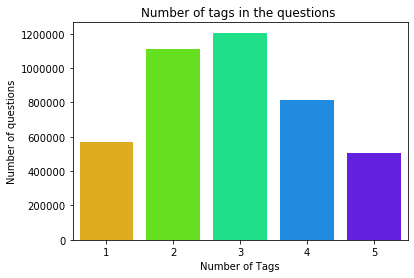

In [19]:
sns.countplot(tags_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

    #2.5 Top 20 tags

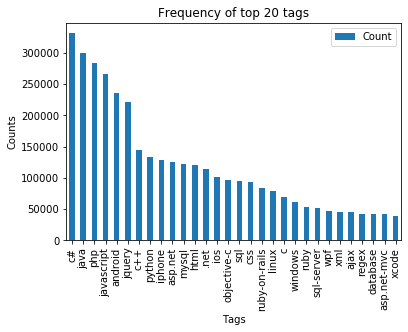

In [23]:
i=np.arange(30)
tag_counts.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_counts['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

# 3 Machine Learning Models

In [11]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [6]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
if os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db')  
    c = conn.cursor()
    c.execute( sql_create_table )
    conn.commit()
    conn.close()
    print("Table QuestionsProcessed crée")
else:
    print("Base donnée absente")
    

Table QuestionsProcessed crée


In [12]:
if os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db')
    if conn is not None:
        writer = conn.cursor()
        start = datetime.now()
        data = pd.read_sql_query("SELECT Title, Body, Tags From Questions LIMIT 1000000;", conn)
        print("Requete executée en", datetime.now()-start)
       

Requete executée en 0:00:19.126563


In [13]:
start = datetime.now()
preprocessed_data_list=[]
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for index, row in data.iterrows():
    
    is_code = 0
    
    title, question, tags = row['Title'], row['Body'], str(row['Tags'])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%50000==0):
        print("number of questions completed=",questions_proccesed)
    
conn.commit()
#writer.close()
conn.close()
no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Longueur moyenne de questions(Title+Body) avant traitement: %d"%no_dup_avg_len_pre)
print( "Longueur moyenne de questions(Title+Body) aprés traitement: %d"%no_dup_avg_len_post)
print ("Pourcentage de questions contenant des codes: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Temps d'exécution est :", datetime.now() - start)

number of questions completed= 50000
number of questions completed= 100000
number of questions completed= 150000
number of questions completed= 200000
number of questions completed= 250000
number of questions completed= 300000
number of questions completed= 350000
number of questions completed= 400000
number of questions completed= 450000
number of questions completed= 500000
number of questions completed= 550000
number of questions completed= 600000
number of questions completed= 650000
number of questions completed= 700000
number of questions completed= 750000
number of questions completed= 800000
number of questions completed= 850000
number of questions completed= 900000
number of questions completed= 950000
number of questions completed= 1000000
Longueur moyenne de questions(Title+Body) avant traitement: 1192
Longueur moyenne de questions(Title+Body) aprés traitement: 408
Pourcentage de questions contenant des codes: 59
Temps d'exécution est : 0:31:37.638865


In [6]:
conn.commit()
#writer.close()
conn.close()
print(conn.isActive())


In [15]:
if os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db')  
    if conn is not None:
        reader =conn.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn.commit()
conn.close()


Questions after preprocessed
('prevent firefox close press ctrl-w prevent firefox close press ctrl-w prevent firefox close press ctrl-w favorit editor vim regular use ctrl-w execut certain action quit often happen firefox activ window window still look vim think vim activ window press ctrl-w close firefox want way stop ctrl-w close firefox rene',)
----------------------------------------------------------------------------------------------------
('error invalid type list variabl error invalid type list variabl error invalid type list variabl import matlab file construct data frame matlab file contain two column row maintain cell matrix construct datafram run random forest get follow error code import matlab file construct datafram structur matlab input file load matlab file',)
----------------------------------------------------------------------------------------------------
('replac special charact url replac special charact url replac special charact url probabl simpl simpli find a

In [9]:
if os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db')
    if conn is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed LIMIT 500000""", conn)
conn.commit()
conn.close()

preprocessed_data.head(10)

,question,tags
0,check upload file imag without mime type check...,php image-processing file-upload upload mime-t...
1,prevent firefox close press ctrl-w prevent fir...,firefox
2,error invalid type list variabl error invalid ...,r matlab machine-learning
3,replac special charact url replac special char...,c# url encoding
4,draw barplot way coreplot draw barplot way cor...,core-plot
5,fetch xml feed use asp.net fetch xml feed use ...,c# asp.net windows-phone-7
6,commerci obfusc achiev crash .net reflector il...,.net obfuscation reflector
7,php framework url convent php framework url co...,php url-routing conventions
8,use printf io monad use printf io monad use pr...,haskell
9,instead br instead br instead br wonder use sp...,html semantic line-breaks


In [3]:
print("nombre de point :", preprocessed_data.shape[0])
print("nombre de dimensions :", preprocessed_data.shape[1])

nombre de point : 500000
nombre de dimensions : 2


In [10]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])
tags = vectorizer.get_feature_names()
print(multilabel_y)

  (0, 19886)	1
  (0, 12207)	1
  (0, 9066)	1
  (0, 28079)	1
  (0, 16198)	1
  (1, 9219)	1
  (2, 21614)	1
  (2, 15619)	1
  (2, 15292)	1
  (3, 3222)	1
  (3, 28105)	1
  (3, 8029)	1
  (4, 5174)	1
  (5, 3222)	1
  (5, 1643)	1
  (5, 29588)	1
  (6, 19)	1
  (6, 18272)	1
  (6, 22087)	1
  (7, 19886)	1
  (7, 28123)	1
  (7, 5099)	1
  (8, 11246)	1
  (9, 11645)	1
  (9, 23581)	1
  :	:
  (499992, 21261)	1
  (499992, 596)	1
  (499993, 11645)	1
  (499993, 13301)	1
  (499993, 8369)	1
  (499993, 14860)	1
  (499994, 29849)	1
  (499994, 29850)	1
  (499994, 1353)	1
  (499994, 1354)	1
  (499995, 19886)	1
  (499995, 14811)	1
  (499996, 13840)	1
  (499996, 29820)	1
  (499996, 23597)	1
  (499996, 19753)	1
  (499997, 13234)	1
  (499997, 17041)	1
  (499997, 24536)	1
  (499997, 8470)	1
  (499998, 15619)	1
  (499998, 25898)	1
  (499999, 14818)	1
  (499999, 28072)	1
  (499999, 24555)	1


In [10]:
print(multilabel_y.sum(axis=0).tolist()[0])

[2, 3, 4, 11, 8, 1, 5, 1, 1, 30, 5, 4, 1, 1815, 3, 3, 2, 1, 2, 13582, 29, 205, 4, 420, 617, 3, 1, 105, 70, 1, 3, 8, 19, 3, 7, 2, 1, 12, 4, 12, 1, 2, 3, 7, 2, 5, 7, 11, 3, 1, 8, 2, 1, 3, 4, 1, 2, 4, 3, 1, 1, 1, 4, 14, 3, 3, 1, 2, 3, 1, 3, 3, 145, 334, 95, 1, 2, 1, 215, 1, 45, 16, 1, 1, 11, 1, 30, 8, 11, 2, 2, 11, 27, 41, 92, 2, 1, 1, 3, 2, 1, 2, 477, 1, 3, 1, 4, 7, 4, 4, 1, 4, 1, 1, 9, 5, 7, 18, 48, 3, 6, 3, 1, 5, 14, 6, 3, 5, 14, 23, 1, 2, 4, 1, 2, 1, 2, 1, 4, 3, 1, 1, 3, 1, 134, 225, 5, 3, 1, 2, 1, 1, 11, 2, 1, 2, 26, 4, 14, 6, 1, 2, 7, 12, 18, 6, 1, 1, 30, 6, 1, 31, 2, 1, 1, 2, 31, 1, 15, 4, 4, 3, 32, 1, 1, 2, 1, 2, 38, 1, 5, 2, 3, 1, 11, 3, 25, 1, 11, 2, 1, 3, 16, 1, 2, 1, 8, 2, 4, 1, 4, 38, 22, 100, 15, 7, 72, 1, 646, 133, 6, 5, 1, 6, 17, 4, 40, 11, 3, 4, 2, 4, 5, 5, 9, 5, 12, 6, 88, 6, 12, 10, 1, 18, 3, 1, 41, 2, 7, 5, 38, 35, 2, 3, 3, 7, 28, 20, 2, 6, 51, 132, 46, 1, 6, 1, 119, 1, 1, 26, 5, 4, 4, 3, 1, 124, 2, 33, 3, 2, 8, 16, 11, 1, 4, 5, 2, 15, 5, 5, 15, 1, 3, 1, 8, 9, 3, 1, 1,

In [46]:
#import dill
#model_file = "countvectorizer.pkl"
#dill.dump(vectorizer, open(model_file, "wb"))

In [4]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    chosenTags = [tags[i] for i in sorted_tags_i[:n]]
    return multilabel_yn,chosenTags

def tags_labels_to_choose(allTags, n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)[0]
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [12]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))
    
    

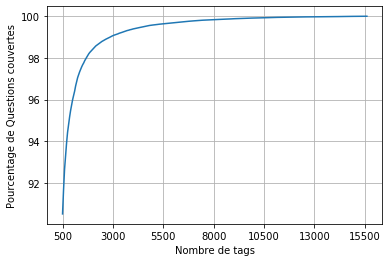

Avec  5500 tags on couvre  99.07 % des questions
Avec  500 tags on couvre  90.518 % des questions
Avec  1000 tags on couvre  95.999 % des questions


In [15]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Nombre de tags")
plt.ylabel("Pourcentage de Questions couvertes")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("Avec ",5500,"tags on couvre ",questions_explained[50],"% des questions")
print("Avec ",500,"tags on couvre ",questions_explained[0],"% des questions")
print("Avec ",1000,"tags on couvre ",questions_explained[10],"% des questions")

In [13]:
multilabel_yx,chosenTags = tags_to_choose(1000)
print("Nombre de questions non couvertes est :", questions_explained_fn(1000),"de ", total_qs)

Nombre de questions non couvertes est : 27811 de  500000


In [20]:
import pickle
with open("tags.txt","wb") as tagsfile:
    pickle.dump(chosenTags,tagsfile)
print(chosenTags)

['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'asp.net', 'iphone', 'mysql', 'html', '.net', 'ios', 'objective-c', 'sql', 'css', 'ruby-on-rails', 'c', 'linux', 'windows', 'ruby', 'sql-server', 'wpf', 'xml', 'ajax', 'asp.net-mvc', 'regex', 'database', 'xcode', 'django', 'arrays', 'facebook', 'vb.net', 'json', 'eclipse', 'ruby-on-rails-3', 'osx', 'string', 'multithreading', 'performance', 'winforms', 'visual-studio-2010', 'asp.net-mvc-3', 'html5', 'image', 'windows-7', 'wordpress', 'algorithm', 'forms', 'homework', 'web-services', 'git', 'query', 'wcf', 'visual-studio', 'linq', 'oracle', 'r', 'spring', 'security', 'bash', 'perl', 'sql-server-2008', 'apache', 'swing', 'ipad', 'actionscript-3', 'cocoa', 'excel', 'flash', 'hibernate', 'silverlight', 'ubuntu', 'networking', 'cocoa-touch', 'entity-framework', 'file', 'api', 'email', 'node.js', 'jquery-ui', 'sqlite', 'list', 'qt', 'flex', '.htaccess', 'delphi', 'internet-explorer', 'tsql', 'codeigniter', 'matlab', 'g

In [21]:
with open("tags.txt", "rb") as ft:
    b = pickle.load(ft)
print(b)


['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'asp.net', 'iphone', 'mysql', 'html', '.net', 'ios', 'objective-c', 'sql', 'css', 'ruby-on-rails', 'c', 'linux', 'windows', 'ruby', 'sql-server', 'wpf', 'xml', 'ajax', 'asp.net-mvc', 'regex', 'database', 'xcode', 'django', 'arrays', 'facebook', 'vb.net', 'json', 'eclipse', 'ruby-on-rails-3', 'osx', 'string', 'multithreading', 'performance', 'winforms', 'visual-studio-2010', 'asp.net-mvc-3', 'html5', 'image', 'windows-7', 'wordpress', 'algorithm', 'forms', 'homework', 'web-services', 'git', 'query', 'wcf', 'visual-studio', 'linq', 'oracle', 'r', 'spring', 'security', 'bash', 'perl', 'sql-server-2008', 'apache', 'swing', 'ipad', 'actionscript-3', 'cocoa', 'excel', 'flash', 'hibernate', 'silverlight', 'ubuntu', 'networking', 'cocoa-touch', 'entity-framework', 'file', 'api', 'email', 'node.js', 'jquery-ui', 'sqlite', 'list', 'qt', 'flex', '.htaccess', 'delphi', 'internet-explorer', 'tsql', 'codeigniter', 'matlab', 'g

In [16]:
train_datasize = 400000
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - train_datasize)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [17]:
print("Nombre de points dans les données d'entrainement :", y_train.shape)
print("Nombre de points dans les données de tets :", y_test.shape)

Nombre de points dans les données d'entrainement : (400000, 1000)
Nombre de points dans les données de tets : (100000, 1000)


In [26]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,2))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Temps d'execution :", datetime.now() - start)

Temps d'execution : 0:01:24.022999


In [19]:
#import dill
#model_file = "tfidfvector.pkl"
#dill.dump(vectorizer, open(model_file, "wb"))

TypeError: __init__() got an unexpected keyword argument 'compress'

In [13]:
print("Dimensions de données d'entrainement X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions de données de test X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions de données d'entrainement X: (400000, 80796) Y : (400000, 1000)
Dimensions de données de test X: (100000, 80796) Y: (100000, 1000)


In [41]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Temps de calcul :", datetime.now() - start)

Accuracy : 0.18108
Hamming loss  0.00164018
Micro-average quality numbers
Precision: 0.7355, Recall: 0.3426, F1-measure: 0.4675
Macro-average quality numbers
Precision: 0.5453, Recall: 0.2382, F1-measure: 0.3135
              precision    recall  f1-score   support

           0       0.68      0.29      0.40      8122
           1       0.83      0.44      0.58      7448
           2       0.87      0.55      0.67      6983
           3       0.77      0.42      0.54      6685
           4       0.95      0.73      0.83      5922
           5       0.86      0.62      0.72      5526
           6       0.87      0.49      0.63      3627
           7       0.90      0.61      0.73      3357
           8       0.82      0.41      0.55      3103
           9       0.70      0.38      0.50      2890
          10       0.87      0.61      0.71      2960
          11       0.60      0.21      0.31      2973
          12       0.65      0.14      0.23      2766
          13       0.64      0.

In [2]:
#from sklearn.externals import joblib

#model_file = "model.pkl"
#joblib.dump(classifier, model_file, compress=3)

['model.pkl']

In [3]:
#from sklearn.externals import joblib

#classifier = joblib.load("model.pkl")


In [15]:
#import dill
#vectfile = open("tfidfvectorizer.pkl","rb")
#vectorizer = dill.load(vectfile)

In [53]:
#countvectfile = open("countvectorizer.pkl","rb")
#countvecto = dill.load(countvectfile)
#print(countvecto.get_feature_names())

['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store', '.each', '.emf', '.exe', '.hgtags', '.htaccess', '.htpasswd', '.ico', '.lib', '.lrc', '.mov', '.net', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.0-beta-2', '.net-4.0-rc1', '.net-4.5', '.net-assembly', '.net-authorization', '.net-cf-3.5', '.net-client-profile', '.net-framework', '.net-framework-source', '.net-framework-version', '.net-gadgeteer', '.net-install', '.net-micro-framework', '.net-reflector', '.net-remoting', '.net-services', '.net2.0', '.net3.5', '.net4.0', '.netrc', '.nettiers', '.obj', '.post', '.procmailrc', '.profile', '.rdlc', '.sdf', '.vdproj', '.war', '.wav', '.when', '.x', '1080p', '10gbethernet', '10gen-csharp-driver', '12.10', '120hz', '16-bit', '16bit', '1and1', '1wire', '2-3-4-tree', '2-digit-year', '2-legged', '2-tier', '2-way-object-databinding', '2003', '2007', '2010', '2013', '24bit', '24hour', '2checkout', '2d', '2d-3d-conversion', '2

In [16]:
title = "How to represent C# byte in Typescript"
questionS="<p>I have a c# class that has one property defined as nullable byte. How would I define that in a TypeScript Interface that I'm using in Angualar 9? The property looks like this:</p>\n\n<pre><code>public byte? CrawfordStatus { get; set; }\n</code></pre>\n"
questionS=re.sub('<code>(.*?)</code>', '', questionS, flags=re.MULTILINE|re.DOTALL)
questionS=striphtml(questionS.encode('utf-8'))
title=title.encode('utf-8')
questionS=str(title)+" "+str(title)+" "+str(title)+" "+questionS
questionS=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',questionS)
wordsS=word_tokenize(str(questionS.lower()))
questionS=' '.join(str(stemmer.stem(j)) for j in wordsS if j not in stop_words and (len(j)!=1 or j=='c'))
    
question = pd.DataFrame([questionS])

print(question)

questionlabel = vectorizer.transform(question[0])
print(questionlabel.shape[1])

                                                   0
0  repres c byte typescript repres c byte typescr...
80796


In [17]:
prediction = classifier.predict(questionlabel)
print(questionlabel.shape[1])
print(prediction)


80796
  (0, 0)	1


In [18]:
def getPredictedTags(prediction):
    return [chosenTags[i] for i in range(0,1000) if prediction[0,i]==1]
print(getPredictedTags(prediction))



['c#']
